# Bank Churn
  
  <br/><br/>
 

This project aims to identify the most important factors leading to customer churn for a commercial bank.

- 11 tables
- A variety of indexes, primary and foreign key constraints
- Over 15,000 rows of data  


  
Finally, we will export the database tables in **CSV** format, which will be used to create a semantic model in **Power BI** and related dashboards in the next step.  
  
  <br/><br/>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import warnings

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [6]:
# create a dataframe from CSV
df = pd.read_csv('../data/0-external/Churn_Banking_Modeling.csv', low_memory=False, encoding='latin-1')
df

In [7]:
# check the shape
df.shape

(377369, 43)

In [8]:
# check the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Id_Cliente                           377369 non-null  int64  
 1   Flag_Richiesta_Estinzione_cc         377369 non-null  object 
 2   Imp_Valore_del_Cliente               377369 non-null  float64
 3   Flag_Apertura_Conto_Online           377369 non-null  int64  
 4   Flag_Possesso_piu_Conti              377369 non-null  int64  
 5   Eta                                  377362 non-null  float64
 6   Provincia_Domicilio                  356181 non-null  object 
 7   Provincia_Residenza                  357897 non-null  object 
 8   Anno_Apertura_primo_Conto            377369 non-null  float64
 9   Professione                          341172 non-null  object 
 10  Imp_Reddito                          157476 non-null  object 
 11  Tipologia_Cli

In [9]:
# check for duplicate rows
df.duplicated().sum()

0

Column names are in **Italian**, they will be translated into English for clarity.

In [10]:
# update column names
df.columns = ['customer_id', 'flag_closure_request', 'amt_cust_value', 'flag_online_acc_opening',
              'flag_mult_account_ownership', 'num_cust_age', 'prov_domicile', 'prov_residence',
              'num_first_account_open_year', 'cust_profession', 'cust_income', 'cust_type', 'cust_gender',
              'mifid_profile', 'amt_pricing_fee', 'amt_transfer_to_competitors', 'amt_transfer_to_non_competitors',
              'num_existing_services', 'flag_salary_deposit', 'amt_credit_card_spending', 'amt_debit_card_spending',
              'num_website_access_count', 'num_device_transactions_count', 'num_trading_activities_count',
              'num_change_services', 'flag_mortgage', 'flag_loan', 'flag_internal_tranfers', 'flag_info_closure_request',
              'flag_loyalty_program_enrol', 'flag_call_center_contact', 'flag_salary_deposit_variation',
              'num_loyalty_points', 'amt_current_liquidity', 'amt_current_managed', 'amt_current_administered',
              'amt_6m_current_liquidity', 'amt_6m_current_managed', 'amt_6m_current_administered',
              'flag_outgoing_sec_tranfer', 'flag_card_rejection', 'flag_loan_rejection', 'flag_rid_deactivation']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 43 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   customer_id                      377369 non-null  int64  
 1   flag_closure_request             377369 non-null  object 
 2   amt_cust_value                   377369 non-null  float64
 3   flag_online_acc_opening          377369 non-null  int64  
 4   flag_mult_account_ownership      377369 non-null  int64  
 5   num_cust_age                     377362 non-null  float64
 6   prov_domicile                    356181 non-null  object 
 7   prov_residence                   357897 non-null  object 
 8   num_first_account_open_year      377369 non-null  float64
 9   cust_profession                  341172 non-null  object 
 10  cust_income                      157476 non-null  object 
 11  cust_type                        377369 non-null  object 
 12  cu

In [12]:
# check for missing values
df.isnull().sum()

customer_id                             0
flag_closure_request                    0
amt_cust_value                          0
flag_online_acc_opening                 0
flag_mult_account_ownership             0
num_cust_age                            7
prov_domicile                       21188
prov_residence                      19472
num_first_account_open_year             0
cust_profession                     36197
cust_income                        219893
cust_type                               0
cust_gender                             7
mifid_profile                       49257
amt_pricing_fee                     27396
amt_transfer_to_competitors        288655
amt_transfer_to_non_competitors    176679
num_existing_services              167432
flag_salary_deposit                     0
amt_credit_card_spending           164706
amt_debit_card_spending            176004
num_website_access_count            50199
num_device_transactions_count       61605
num_trading_activities_count      

In [13]:
# drop 'customer_id' column
df.drop(columns='customer_id', inplace=True)

In [14]:
# check the shape
df.shape

(377369, 42)

In [15]:
# build a data dictionary which includes variable type and description for all features
data_dict = {'flag_closure_request':['binary-target', 'A binary flag indicating whether the customer has requested the closure of their account (1) or not (0)'],
             'amt_cust_value':['continuous', 'The total value or worth of the customer to the bank, which could be calculated based on factors such as their account balances, investments, loan amounts, etc'],
             'flag_online_acc_opening':['binary', 'A binary flag indicating whether the customer opened their account online (1) or not (0)'],
             'flag_mult_account_ownership':['binary', 'A binary flag indicating whether the customer owns multiple accounts with the bank (1) or not (0)'],
             'num_cust_age':['discrete', 'The age of the customer in years'],
             'prov_domicile':['nominal', 'The province where the customer is officially registered or has their legal residence'],
             'prov_residence':['nominal', 'The province where the customer currently resides or lives'],
             'num_first_account_open_year':['discrete', 'The year in which the customer opened their first account with the bank'],
             'cust_profession':['nominal', 'The occupation or job role of the customer'],
             'cust_income':['ordinal', 'The level of income earned by the customer, typically expressed in the currency of the country'],
             'cust_type':['ordinal', 'A categorization or classification of customers based on certain criteria or attributes'],
             'cust_gender':['binary', 'The gender of the customer (e.g., Male, Female, Other)'],
             'mifid_profile':['ordinal', 'A customer profile classification based on the Markets in Financial Instruments Directive (MiFID), which regulates investment services within the European Economic Area'],
             'amt_pricing_fee':['continuous', 'The amount of fees charged to the customer for various services, transactions, or account maintenance, expressed in the currency of the country (cc)'],
             'amt_transfer_to_competitors':['continuous', 'The amount of money transferred by the customer to other banks or financial institutions compared to their competitors'],
             'amt_transfer_to_non_competitors':['continuous', 'The amount of money transferred by the customer to other banks or financial institutions compared to non-competitors, such as internal transfers within the same bank'],
             'num_existing_services':['discrete', 'The total number of different banking services or products (e.g., accounts, loans, credit cards) that the customer currently has with the bank'],
             'flag_salary_deposit':['binary', 'A binary flag indicating whether the customer receives their salary or income deposits into their bank account (1) or not (0)'],
             'amt_credit_card_spending':['continuous', 'The amount of money spent by the customer using credit cards'],
             'amt_debit_card_spending':['continuous', 'The amount of money spent by the customer using debit cards'],
             'num_website_access_count':['discrete', 'The count or frequency of the customer access or visits to the bank website'],
             'num_device_transactions_count':['continuous', 'The count or frequency of the customer transactions using devices such as smartphones, tablets, or computers'],
             'num_trading_activities_count':['continuous', 'The count or frequency of the customer trading activities, which could include buying'],
             'num_change_services':['discrete', 'Change in the number of utilities in the last 6 months'],
             'flag_mortgage':['binary', '1 if the customer has an active mortgage, 0 otherwise'],
             'flag_loan':['binary', '1 if the customer has an active loan, 0 otherwise'],
             'flag_internal_tranfers':['binary', '1 if the customer has made transfers in the last 6 months, 0 otherwise'],
             'flag_info_closure_request':['binary', 'A binary flag indicating whether the customer has requested information regarding the closure of their account (1) or not (0)'],
             'flag_loyalty_program_enrol':['binary', 'A binary flag indicating whether the customer is enrolled in a loyalty program offered by the bank (1) or not (0)'],
             'flag_call_center_contact':['binary', 'A binary flag indicating whether the customer has had contact with the bank call center (1) or not (0)'],
             'flag_salary_deposit_variation':['binary', 'A binary flag indicating whether there has been a variation or change in the customer salary or income deposits into their bank account'],
             'num_loyalty_points':['discrete', 'The total number of loyalty program points accumulated by the customer'],
             'amt_current_liquidity':['continuous', 'The amount of liquid assets (e.g., cash, savings) currently held by the customer'],
             'amt_current_managed':['continuous', 'The amount of assets currently being managed by the bank on behalf of the customer (e.g., investments, portfolios)'],
             'amt_current_administered':['continuous', 'The amount of assets or funds currently administered by the bank on behalf of the customer (e.g., trust funds, estates)'],
             'amt_6m_current_liquidity':['continuous', 'The average amount of liquid assets held by the customer over the past 6 months'],
             'amt_6m_current_managed':['continuous', 'The average amount of assets being managed by the bank for the customer over the past 6 months'],
             'amt_6m_current_administered':['continuous', 'The average amount of assets or funds administered by the bank for the customer over the past 6 months'],
             'flag_outgoing_sec_tranfer':['binary', 'A binary flag indicating whether the customer has made outgoing transfers of securities (e.g., stocks, bonds) to other financial institutions (1) or not (0)'],
             'flag_card_rejection':['binary', 'A binary flag indicating whether the customer card transactions have been rejected by the bank (1) or not (0)'],
             'flag_loan_rejection':['binary', 'A binary flag indicating whether the customer loan applications have been rejected by the bank (1) or not (0)'],
             'flag_rid_deactivation':['binary', 'A binary flag indicating whether the customer Remote Banking ID (RID) has been deactivated (1) or not (0)']}
             

In [16]:
# split variables into continuous, discrete, ordinal, nominal and binary
continuous_vars = []
discrete_vars =   []
ordinal_vars =    []
nominal_vars =    []
binary_vars =     []

for k,v in data_dict.items():
    if v[0] == 'continuous':
        continuous_vars.append(k)
    elif v[0] == 'discrete':
        discrete_vars.append(k)
    elif v[0] == 'ordinal':
        ordinal_vars.append(k)
    elif v[0] == 'nominal':
        nominal_vars.append(k)
    elif v[0] == 'binary':
        binary_vars.append(k)

In [17]:
# define quantitative and categorical variables
quant_vars = continuous_vars + discrete_vars
categ_vars = ordinal_vars + nominal_vars + binary_vars
target = ['flag_closure_request']

In [18]:
# display variable types
print('TYPOLOGIES OF VARIABLES')
print('Continuous variables:', len(continuous_vars))
print('Discrete variables:  ', len(discrete_vars))
print('Ordinal variables:   ', len(ordinal_vars))
print('Nominal variables:   ', len(nominal_vars))
print('Binary variables:    ', len(binary_vars+target))
print()
print()
print('CONTINUOUS VARIABLES \n', continuous_vars)
print()
print('DISCRETE VARIABLES \n', discrete_vars)
print()
print('ORDINAL VARIABLES \n', ordinal_vars)
print()
print('NOMINAL VARIABLES \n', nominal_vars)
print()
print('BINARY VARIABLES \n', binary_vars+target)
print()

TYPOLOGIES OF VARIABLES
Continuous variables: 14
Discrete variables:   6
Ordinal variables:    3
Nominal variables:    3
Binary variables:     16


CONTINUOUS VARIABLES 
 ['amt_cust_value', 'amt_pricing_fee', 'amt_transfer_to_competitors', 'amt_transfer_to_non_competitors', 'amt_credit_card_spending', 'amt_debit_card_spending', 'num_device_transactions_count', 'num_trading_activities_count', 'amt_current_liquidity', 'amt_current_managed', 'amt_current_administered', 'amt_6m_current_liquidity', 'amt_6m_current_managed', 'amt_6m_current_administered']

DISCRETE VARIABLES 
 ['num_cust_age', 'num_first_account_open_year', 'num_existing_services', 'num_website_access_count', 'num_change_services', 'num_loyalty_points']

ORDINAL VARIABLES 
 ['cust_income', 'cust_type', 'mifid_profile']

NOMINAL VARIABLES 
 ['prov_domicile', 'prov_residence', 'cust_profession']

BINARY VARIABLES 
 ['flag_online_acc_opening', 'flag_mult_account_ownership', 'cust_gender', 'flag_salary_deposit', 'flag_mortgage',

## Inspecting missing values

In [19]:
# display the total number of cells
total_cells = np.product(df.shape)
total_cells

15849498

In [20]:
# display the total number of missing values
total_missing = df.isna().sum().sum()
total_missing

3291646

In [21]:
# display the percentage of data that is missing
(total_missing/total_cells) * 100

20.768140416813203

In [22]:
# count the missing values for each column, display only the ones with missing values
na_count = df.isna().sum()
na_count[na_count != 0]

num_cust_age                            7
prov_domicile                       21188
prov_residence                      19472
cust_profession                     36197
cust_income                        219893
cust_gender                             7
mifid_profile                       49257
amt_pricing_fee                     27396
amt_transfer_to_competitors        288655
amt_transfer_to_non_competitors    176679
num_existing_services              167432
amt_credit_card_spending           164706
amt_debit_card_spending            176004
num_website_access_count            50199
num_device_transactions_count       61605
num_trading_activities_count       290438
num_change_services                159014
flag_salary_deposit_variation      219893
num_loyalty_points                 250130
amt_current_liquidity                   5
amt_current_managed                266181
amt_current_administered           189735
amt_6m_current_liquidity               13
amt_6m_current_managed            

Several features have a lot of missing values (NaN).  
The way to process them will be based on their **variable types** and their **unique values**.  

In [23]:
# display features unique values
for f in na_count[na_count != 0].index:
    print(f.upper())
    print(df[f].unique())
    print()
    print()

NUM_CUST_AGE
[ 38.  45.  61.  33.  36.  48.  51.  44.  63.  32.  66.  57.  60.  40.
  49.  31.  35.  46.  42.  50.  37.  41.  39.  47.  71.  77.  54.  70.
  24.  78.  55.  58.  30.  29.  43.  56.  64.  76.  59.  65.  86.  72.
  73.  53.  81.  62.  68.  34.  74.  27.  26.  28.  79.  69.  19.  52.
  75.  67.  23.  25.  22.  87.  21.  82.  80.  83.  85.  91.  97.  84.
  90.  89.  20.  94.  88.  18.  92.  93.  16.  17.  13. 102.  99.  96.
   5.  11. 101.  14. 132. 105.  95.  98.  10.   3.   9. 100.   7.  nan
  12.   4.   6.   8.  15.]


PROV_DOMICILE
['BO' 'SA' 'VT' 'MI' 'AL' 'NO' 'BZ' 'MO' 'CT' 'RN' 'RE' 'FI' 'AV' 'PN'
 'TR' 'GE' 'VI' 'FR' 'FM' 'CR' 'RM' nan 'TO' 'PD' 'CA' 'CE' 'SR' 'BI' 'PI'
 'CO' 'CB' 'MN' 'PU' 'AR' 'PA' 'TE' 'MB' 'VA' 'SP' 'BS' 'RA' 'CI' 'PV'
 'FE' 'LU' 'PR' 'PT' 'UD' 'MC' 'FG' 'LT' 'BA' 'PO' 'TA' 'LC' 'VE' 'TP'
 'PG' 'SI' 'TN' 'GO' 'TV' 'BG' 'MS' 'CH' 'VR' 'FC' 'LI' 'GR' 'LE' 'VC'
 'OR' 'LO' 'EE' 'AQ' 'SV' 'RC' 'RG' 'SS' 'CS' 'PZ' 'AT' 'ME' 'CL' 'BR'
 'MT' 'RO' 'TS' '

In [24]:
# display the statistical summary of the numerical features
df.describe()

,amt_cust_value,flag_online_acc_opening,flag_mult_account_ownership,num_cust_age,num_first_account_open_year,amt_pricing_fee,amt_transfer_to_competitors,amt_transfer_to_non_competitors,num_existing_services,flag_salary_deposit,amt_credit_card_spending,amt_debit_card_spending,num_website_access_count,num_device_transactions_count,num_trading_activities_count,num_change_services,flag_mortgage,flag_loan,flag_internal_tranfers,flag_info_closure_request,flag_loyalty_program_enrol,flag_call_center_contact,flag_salary_deposit_variation,num_loyalty_points,amt_current_liquidity,amt_current_managed,amt_current_administered,amt_6m_current_liquidity,amt_6m_current_managed,amt_6m_current_administered,flag_outgoing_sec_tranfer,flag_card_rejection,flag_loan_rejection,flag_rid_deactivation
count,377369.000000,377369.000000,377369.000000,377362.000000,377369.000000,349973.000000,8.871400e+04,2.006900e+05,209937.000000,377369.000000,212663.000000,201365.000000,327170.000000,315764.000000,86931.000000,218355.000000,377369.000000,377369.000000,377369.000000,377369.000000,377369.000000,377369.000000,157476.000000,127239.000000,3.773640e+05,1.111880e+05,1.876340e+05,3.773560e+05,1.109000e+05,1.862980e+05,377369.000000,377369.000000,377369.000000,377369.000000
mean,644.662654,0.234230,0.071818,46.039890,2004.805750,0.903291,3.183130e+03,3.352734e+03,4.454517,0.417300,503.149146,337.938624,8.041092,10.012889,15.143344,0.198044,0.002165,0.029586,0.149511,0.000607,0.337174,0.360454,-0.089633,1045.617303,1.513478e+04,6.770461e+04,7.614477e+04,1.532084e+04,6.554481e+04,7.233862e+04,0.008358,0.000917,0.008008,0.000845
std,2928.725757,0.423517,0.258187,13.146689,3.288509,1.825685,1.423111e+04,1.511987e+04,3.636854,0.493114,510.779493,510.884365,7.225131,22.984360,78.764646,1.071767,0.046479,0.169444,0.356592,0.024627,0.472745,0.480133,0.319666,3515.585203,5.204623e+04,1.940914e+05,2.669638e+05,5.201275e+04,1.780930e+05,2.637481e+05,0.091039,0.030266,0.089129,0.029062
min,0.000000,0.000000,0.000000,3.000000,1994.000000,0.000000,1.000000e-02,1.000000e-02,1.000000,0.000000,0.010000,0.010000,1.000000,1.000000,1.000000,-26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-50.000000,-2.998609e+06,0.000000e+00,0.000000e+00,-2.990061e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,46.870000,0.000000,0.000000,37.000000,2002.000000,0.000000,1.575825e+02,3.500000e+02,2.000000,0.000000,174.649167,130.670000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,6.292100e+02,7.880375e+03,4.966840e+03,6.313775e+02,7.808850e+03,4.937938e+03,0.000000,0.000000,0.000000,0.000000
50%,97.270000,0.000000,0.000000,43.000000,2005.000000,0.000000,4.790000e+02,8.058555e+02,3.000000,0.000000,363.346666,261.422500,5.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,495.000000,3.850860e+03,2.329358e+04,2.084153e+04,3.788385e+03,2.284953e+04,2.016169e+04,0.000000,0.000000,0.000000,0.000000
75%,370.320000,0.000000,0.000000,54.000000,2008.000000,0.325000,1.500000e+03,2.047996e+03,6.000000,1.000000,669.673333,461.661666,12.000000,15.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1065.000000,1.417872e+04,6.469545e+04,6.766876e+04,1.397786e+04,6.297351e+04,6.434840e+04,0.000000,0.000000,0.000000,0.000000
max,377934.870000,1.000000,1.000000,132.000000,2010.000000,5.950000,1.100000e+06,1.130700e+06,40.000000,1.000000,27621.971666,181522.121666,30.000000,11379.000000,6812.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,427530.000000,1.686020e+07,1.736378e+07,4.808764e+07,1.486619e+07,1.838148e+07,5.715864e+07,1.000000,1.000000,1.000000,1.000000


In [25]:
# save the modified dataframe as CSV
df.to_csv('../data/3-processed/df_00.csv', encoding='latin-1', index=False)

In [26]:
# load data from CSV for consistency reasons
df = pd.read_csv('../data/3-processed/df_00.csv', low_memory=False, encoding='latin-1')
df

In [27]:
# display the unique values
df['flag_closure_request'].unique()

array(['no', 'si'], dtype=object)

The **'flag_closure_request'** column has no empty values and will be binarised for analytical purposes.

In [28]:
# convert 'flag_closure_request' column into binary
df.flag_closure_request[df.flag_closure_request == 'si'] = 1
df.flag_closure_request[df.flag_closure_request == 'no'] = 0
df['flag_closure_request'] = df['flag_closure_request'].astype('int64')
df

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   flag_closure_request             377369 non-null  int64  
 1   amt_cust_value                   377369 non-null  float64
 2   flag_online_acc_opening          377369 non-null  int64  
 3   flag_mult_account_ownership      377369 non-null  int64  
 4   num_cust_age                     377362 non-null  float64
 5   prov_domicile                    356181 non-null  object 
 6   prov_residence                   357897 non-null  object 
 7   num_first_account_open_year      377369 non-null  float64
 8   cust_profession                  341172 non-null  object 
 9   cust_income                      157476 non-null  object 
 10  cust_type                        377369 non-null  object 
 11  cust_gender                      377362 non-null  object 
 12  mi

In [30]:
# display the unique values
df['flag_online_acc_opening'].unique()

array([0, 1], dtype=int64)

In [31]:
# display the unique values
df['num_cust_age'].unique()

array([ 38.,  45.,  61.,  33.,  36.,  48.,  51.,  44.,  63.,  32.,  66.,
        57.,  60.,  40.,  49.,  31.,  35.,  46.,  42.,  50.,  37.,  41.,
        39.,  47.,  71.,  77.,  54.,  70.,  24.,  78.,  55.,  58.,  30.,
        29.,  43.,  56.,  64.,  76.,  59.,  65.,  86.,  72.,  73.,  53.,
        81.,  62.,  68.,  34.,  74.,  27.,  26.,  28.,  79.,  69.,  19.,
        52.,  75.,  67.,  23.,  25.,  22.,  87.,  21.,  82.,  80.,  83.,
        85.,  91.,  97.,  84.,  90.,  89.,  20.,  94.,  88.,  18.,  92.,
        93.,  16.,  17.,  13., 102.,  99.,  96.,   5.,  11., 101.,  14.,
       132., 105.,  95.,  98.,  10.,   3.,   9., 100.,   7.,  nan,  12.,
         4.,   6.,   8.,  15.])

In [32]:
# display the unique values
df['prov_domicile'].unique()

array(['BO', 'SA', 'VT', 'MI', 'AL', 'NO', 'BZ', 'MO', 'CT', 'RN', 'RE',
       'FI', 'AV', 'PN', 'TR', 'GE', 'VI', 'FR', 'FM', 'CR', 'RM', nan,
       'TO', 'PD', 'CA', 'CE', 'SR', 'BI', 'PI', 'CO', 'CB', 'MN', 'PU',
       'AR', 'PA', 'TE', 'MB', 'VA', 'SP', 'BS', 'RA', 'CI', 'PV', 'FE',
       'LU', 'PR', 'PT', 'UD', 'MC', 'FG', 'LT', 'BA', 'PO', 'TA', 'LC',
       'VE', 'TP', 'PG', 'SI', 'TN', 'GO', 'TV', 'BG', 'MS', 'CH', 'VR',
       'FC', 'LI', 'GR', 'LE', 'VC', 'OR', 'LO', 'EE', 'AQ', 'SV', 'RC',
       'RG', 'SS', 'CS', 'PZ', 'AT', 'ME', 'CL', 'BR', 'MT', 'RO', 'TS',
       'PC', 'CN', 'AG', 'RI', 'PE', 'CZ', 'IM', 'AP', 'AN', 'BT', 'VS',
       'NU', 'BL', 'OT', 'OG', 'BN', 'VB', 'IS', 'AO', 'SO', 'EN', 'KR',
       'VV', 'PS', 'FO', '8N', 'BE'], dtype=object)

In [33]:
# display the unique values
df['prov_residence'].unique()

array(['BO', 'SA', 'VT', 'MI', 'AL', 'NO', 'BZ', 'MO', 'CT', 'RN', 'RE',
       'FI', 'AV', 'PN', 'TR', 'GE', 'VI', 'FR', 'FM', 'CR', 'RM', nan,
       'TO', 'PD', 'CA', 'CE', 'SR', 'BI', 'PI', 'CO', 'FC', 'CB', 'MN',
       'PU', 'BN', 'AR', 'PA', 'TE', 'MB', 'VA', 'BS', 'RA', 'CI', 'PV',
       'FE', 'LU', 'PR', 'PT', 'TS', 'MC', 'FG', 'LT', 'BA', 'PO', 'TA',
       'LC', 'GR', 'VE', 'TP', 'PG', 'SI', 'TN', 'GO', 'UD', 'TV', 'BG',
       'MS', 'CH', 'VR', 'LI', 'LE', 'VC', 'SP', 'SS', 'OR', 'LO', 'AQ',
       'CN', 'RC', 'RG', 'RO', 'CS', 'PZ', 'AT', 'ME', 'CL', 'SV', 'BR',
       'MT', 'PC', 'PE', 'AG', 'RI', 'CZ', 'IM', 'AP', 'AN', 'BT', 'VS',
       'NU', 'BL', 'OT', 'OG', 'VB', 'EE', 'AO', 'IS', 'SO', 'EN', 'KR',
       'VV', 'PS', 'FO'], dtype=object)

In [34]:
# display the unique values
df['num_first_account_open_year'].unique()

array([2004., 2000., 2005., 2010., 2001., 2008., 2002., 2007., 2003.,
       2006., 2009., 1999., 1994., 1995., 1998., 1996., 1997.])

In [35]:
# convert 'num_first_account_year' column into integer
df['num_first_account_open_year'] = df['num_first_account_open_year'].astype('int64')
df['num_first_account_open_year'].unique()

array([2004, 2000, 2005, 2010, 2001, 2008, 2002, 2007, 2003, 2006, 2009,
       1999, 1994, 1995, 1998, 1996, 1997], dtype=int64)

In [36]:
# display the unique values
df['cust_profession'].unique()

array(['Impiegato', 'Altro/Nessuno', 'Quadro', 'Operaio', nan,
       'Ufficiale/Sottufficiale',
       'Libero professionista/Titolare di impresa', 'Dirigente',
       'Commercialista', 'Rappresentante/Agente', 'Ingegnere/Architetto',
       'Avvocato', 'Medico/Farmacista', 'Autotrasportatore',
       'Docente/Insegnante', 'Commesso/Ausiliario',
       'Ufficiale/Sottoufficiale',
       'Libero professionista/Titolare impresa', 'Notaio'], dtype=object)

In [37]:
# display the unique values
df['cust_income'].unique()

array(['Medio (tra 1500 e 1800)', 'Alto (tra 1800 e 2500)',
       'Basso (tra 1200 e 1500)', nan, 'Altissimo (>2500)',
       'Bassissimo (<1200)'], dtype=object)

In [38]:
# display the unique values
df['cust_type'].unique()

array(['Investor', 'Trader', 'ActiveTrader', 'Banker', 'Sleeper'],
      dtype=object)

In [39]:
# display the unique values
df['cust_gender'].unique()

array(['M', 'F', nan], dtype=object)

In [40]:
# display the unique values
df['cust_gender'].value_counts()

M    265032
F    112330
Name: cust_gender, dtype: int64

In [41]:
# display the unique values
df['mifid_profile'].unique()

array(['PRUDENTE', 'BILANCIATO', 'DINAMICO', nan, 'ND', 'CAUTO'],
      dtype=object)

In [42]:
# display the unique values
df['num_existing_services'].unique()

array([ 3.,  7.,  9., nan,  4.,  5., 14.,  1.,  2.,  6., 39.,  8., 13.,
       12., 15., 10., 11., 16., 19., 18., 20., 17., 27., 23., 21., 24.,
       22., 28., 25., 31., 26., 29., 30., 32., 38., 35., 40., 33.])

In [43]:
# display the unique values
df['num_website_access_count'].unique()

array([14., 25., 18.,  4., 16., nan, 12.,  1.,  5.,  6.,  3., 21., 19.,
        7.,  2., 23., 22.,  8., 24., 15., 10.,  9., 17., 20., 13., 11.,
       26., 27., 29., 28., 30.])

In [44]:
# display the unique values
df['num_device_transactions_count'].unique()

array([5.8000e+01, 8.0000e+00, 1.3000e+01, 4.0000e+00, 1.0000e+00,
              nan, 2.1000e+01, 1.0000e+01, 3.0000e+00, 7.0000e+00,
       1.5000e+01, 1.8000e+01, 1.1000e+01, 6.0000e+00, 1.2000e+01,
       9.0000e+00, 2.0000e+00, 3.4000e+01, 2.4000e+01, 5.0000e+00,
       2.6000e+01, 1.4000e+01, 2.0000e+01, 2.2000e+01, 1.6000e+01,
       1.7000e+01, 1.9000e+01, 2.5000e+01, 2.3000e+01, 3.3000e+01,
       2.8000e+01, 4.5000e+01, 3.6000e+01, 3.0000e+01, 4.0000e+01,
       3.2000e+01, 2.9000e+01, 3.7000e+01, 5.5000e+01, 3.5000e+01,
       3.1000e+01, 4.8000e+01, 2.7000e+01, 4.4000e+01, 4.2000e+01,
       5.0000e+01, 6.3000e+01, 4.7000e+01, 3.9000e+01, 4.1000e+01,
       3.8000e+01, 4.3000e+01, 5.1000e+01, 5.4000e+01, 7.1000e+01,
       5.6000e+01, 4.9000e+01, 4.6000e+01, 5.2000e+01, 5.3000e+01,
       6.1000e+01, 5.7000e+01, 6.0000e+01, 9.0000e+01, 1.1500e+02,
       1.0400e+02, 9.4000e+01, 6.5000e+01, 6.2000e+01, 7.4000e+01,
       6.4000e+01, 5.9000e+01, 6.8000e+01, 1.3300e+02, 6.6000e

In [45]:
# display the unique values
df['num_trading_activities_count'].unique()

array([      nan, 2.000e+00, 7.000e+00, 7.200e+01, 1.000e+00, 8.000e+00,
       4.000e+00, 2.400e+01, 1.570e+02, 6.000e+00, 3.000e+00, 1.070e+02,
       1.000e+01, 3.700e+01, 7.300e+01, 9.000e+00, 1.300e+01, 5.000e+00,
       3.800e+01, 2.000e+01, 2.800e+01, 1.400e+01, 2.600e+01, 1.900e+01,
       3.000e+01, 1.700e+01, 3.490e+02, 3.500e+01, 4.070e+02, 5.810e+02,
       9.600e+01, 1.600e+01, 6.100e+01, 1.060e+02, 1.500e+01, 3.100e+01,
       3.200e+01, 1.200e+01, 6.700e+01, 2.100e+01, 2.200e+01, 1.100e+01,
       9.300e+01, 3.900e+01, 1.150e+02, 1.480e+02, 6.600e+02, 1.360e+02,
       1.800e+01, 6.600e+01, 9.700e+01, 4.300e+01, 4.600e+01, 4.100e+01,
       1.830e+02, 2.300e+01, 3.600e+01, 3.480e+02, 5.700e+01, 2.500e+01,
       2.610e+02, 9.500e+01, 3.520e+02, 5.400e+01, 8.300e+01, 8.800e+01,
       7.900e+01, 2.270e+02, 7.600e+01, 2.840e+02, 1.720e+02, 3.400e+01,
       2.900e+01, 6.500e+01, 2.700e+01, 1.260e+02, 1.730e+02, 2.070e+02,
       4.000e+01, 9.800e+01, 1.530e+02, 4.010e+02, 

In [46]:
# display the unique values
df['num_change_services'].unique()

array([  0.,   1.,  -1.,  nan,   2.,  -4., -23.,  -8.,  -5.,  -2.,  -7.,
        -6.,  -3.,   3., -11.,   4.,   5.,  15.,   7.,   6.,   8.,  10.,
        11.,  12., -14., -10.,   9.,  -9.,  16., -12.,  14., -13.,  22.,
        18., -16., -15.,  13.,  17.,  19., -17.,  21.,  20., -26.,  25.])

In [47]:
# check the value percentages for the 'prov_domicile' column
df.prov_domicile.value_counts(normalize=True)

RM    0.147911
MI    0.088186
TO    0.056567
BS    0.029061
GE    0.023951
BG    0.021972
BO    0.021439
CT    0.019911
FI    0.019479
PA    0.019041
SA    0.018218
MB    0.017674
VA    0.014568
CE    0.014394
PD    0.014114
VR    0.013367
LT    0.012870
MO    0.011935
FR    0.011651
PV    0.011629
PG    0.011222
RE    0.010885
TV    0.010792
VE    0.010514
CA    0.010408
BA    0.010349
AN    0.009810
VI    0.009711
LE    0.009557
SR    0.009338
PR    0.008521
CO    0.008490
ME    0.007881
UD    0.007679
RN    0.007566
SP    0.007238
TA    0.007199
PI    0.007030
PU    0.006772
SV    0.006721
FE    0.006561
LU    0.006533
RC    0.006354
NO    0.006320
PO    0.006233
CH    0.006171
AV    0.006118
FC    0.005893
AL    0.005778
LI    0.005747
RA    0.005741
TS    0.005739
AR    0.005455
MC    0.005351
TR    0.005329
PT    0.005303
MN    0.005003
PN    0.004846
CN    0.004787
CR    0.004632
TN    0.004596
PE    0.004506
LC    0.004338
PC    0.004273
MS    0.004085
RG    0.004043
CS    0.00

In [48]:
# check the value percentages for the 'prov_residence' column
df.prov_residence.value_counts(normalize=True)

RM    0.140691
MI    0.081266
TO    0.055709
BS    0.029042
GE    0.024074
BG    0.021883
CT    0.020414
BO    0.020349
PA    0.019620
SA    0.019307
FI    0.018813
MB    0.017064
CE    0.014596
VA    0.014392
PD    0.014188
VR    0.013378
LT    0.013347
FR    0.012006
MO    0.011713
PG    0.011593
PV    0.011319
BA    0.010992
VE    0.010897
TV    0.010877
RE    0.010858
CA    0.010735
LE    0.010349
SR    0.009807
AN    0.009763
VI    0.009698
CO    0.008536
ME    0.008480
PR    0.008477
UD    0.007868
TA    0.007784
RN    0.007477
SP    0.007245
RC    0.006896
SV    0.006876
PU    0.006854
PI    0.006784
FE    0.006697
AV    0.006605
LU    0.006591
CH    0.006524
NO    0.006292
PO    0.006108
AL    0.005960
FC    0.005896
LI    0.005887
TS    0.005801
RA    0.005778
AR    0.005546
MC    0.005460
TR    0.005401
PT    0.005284
MN    0.005122
PN    0.005013
CN    0.004817
TN    0.004797
CS    0.004691
PE    0.004688
CR    0.004415
LC    0.004406
RG    0.004283
PC    0.004241
MS    0.00

In [49]:
# perform ordinal encoding - categorical variables where values are not correctly designated
# note: where the customer does not have the feature ('NA') it will be assigned a value of 0

# map 'cust_income' to encoded values
df['cust_income'] = df['cust_income'].map({'Altissimo (>2500)'       : 5, 
                                           'Alto (tra 1800 e 2500)'  : 4, 
                                           'Medio (tra 1500 e 1800)' : 3, 
                                           'Basso (tra 1200 e 1500)' : 2, 
                                           'Bassissimo (<1200)'      : 1, 
                                           np.nan                    : 0})


# map 'cust_type' to encoded values
df['cust_type'] = df['cust_type'].map({'Banker'       : 4, 
                                       'Investor'     : 3, 
                                       'ActiveTrader' : 2, 
                                       'Trader'       : 1, 
                                       'Sleeper'      : 0})


# map 'mifid_profile' to encoded values
df['mifid_profile'] = df['mifid_profile'].map({'DINAMICO'   : 5, 
                                               'BILANCIATO' : 4, 
                                               'PRUDENTE'   : 3, 
                                               'CAUTO'      : 2, 
                                               'ND'         : 1, 
                                               np.nan       : 0})

In [50]:
# save the modified dataframe as CSV
df.to_csv('../data/3-processed/df_01.csv', encoding='latin-1', index=False)

In [51]:
# load data from CSV for consistency reasons
df = pd.read_csv('../data/3-processed/df_01.csv', low_memory=False, encoding='latin-1')

## Exploratory Data Analysis

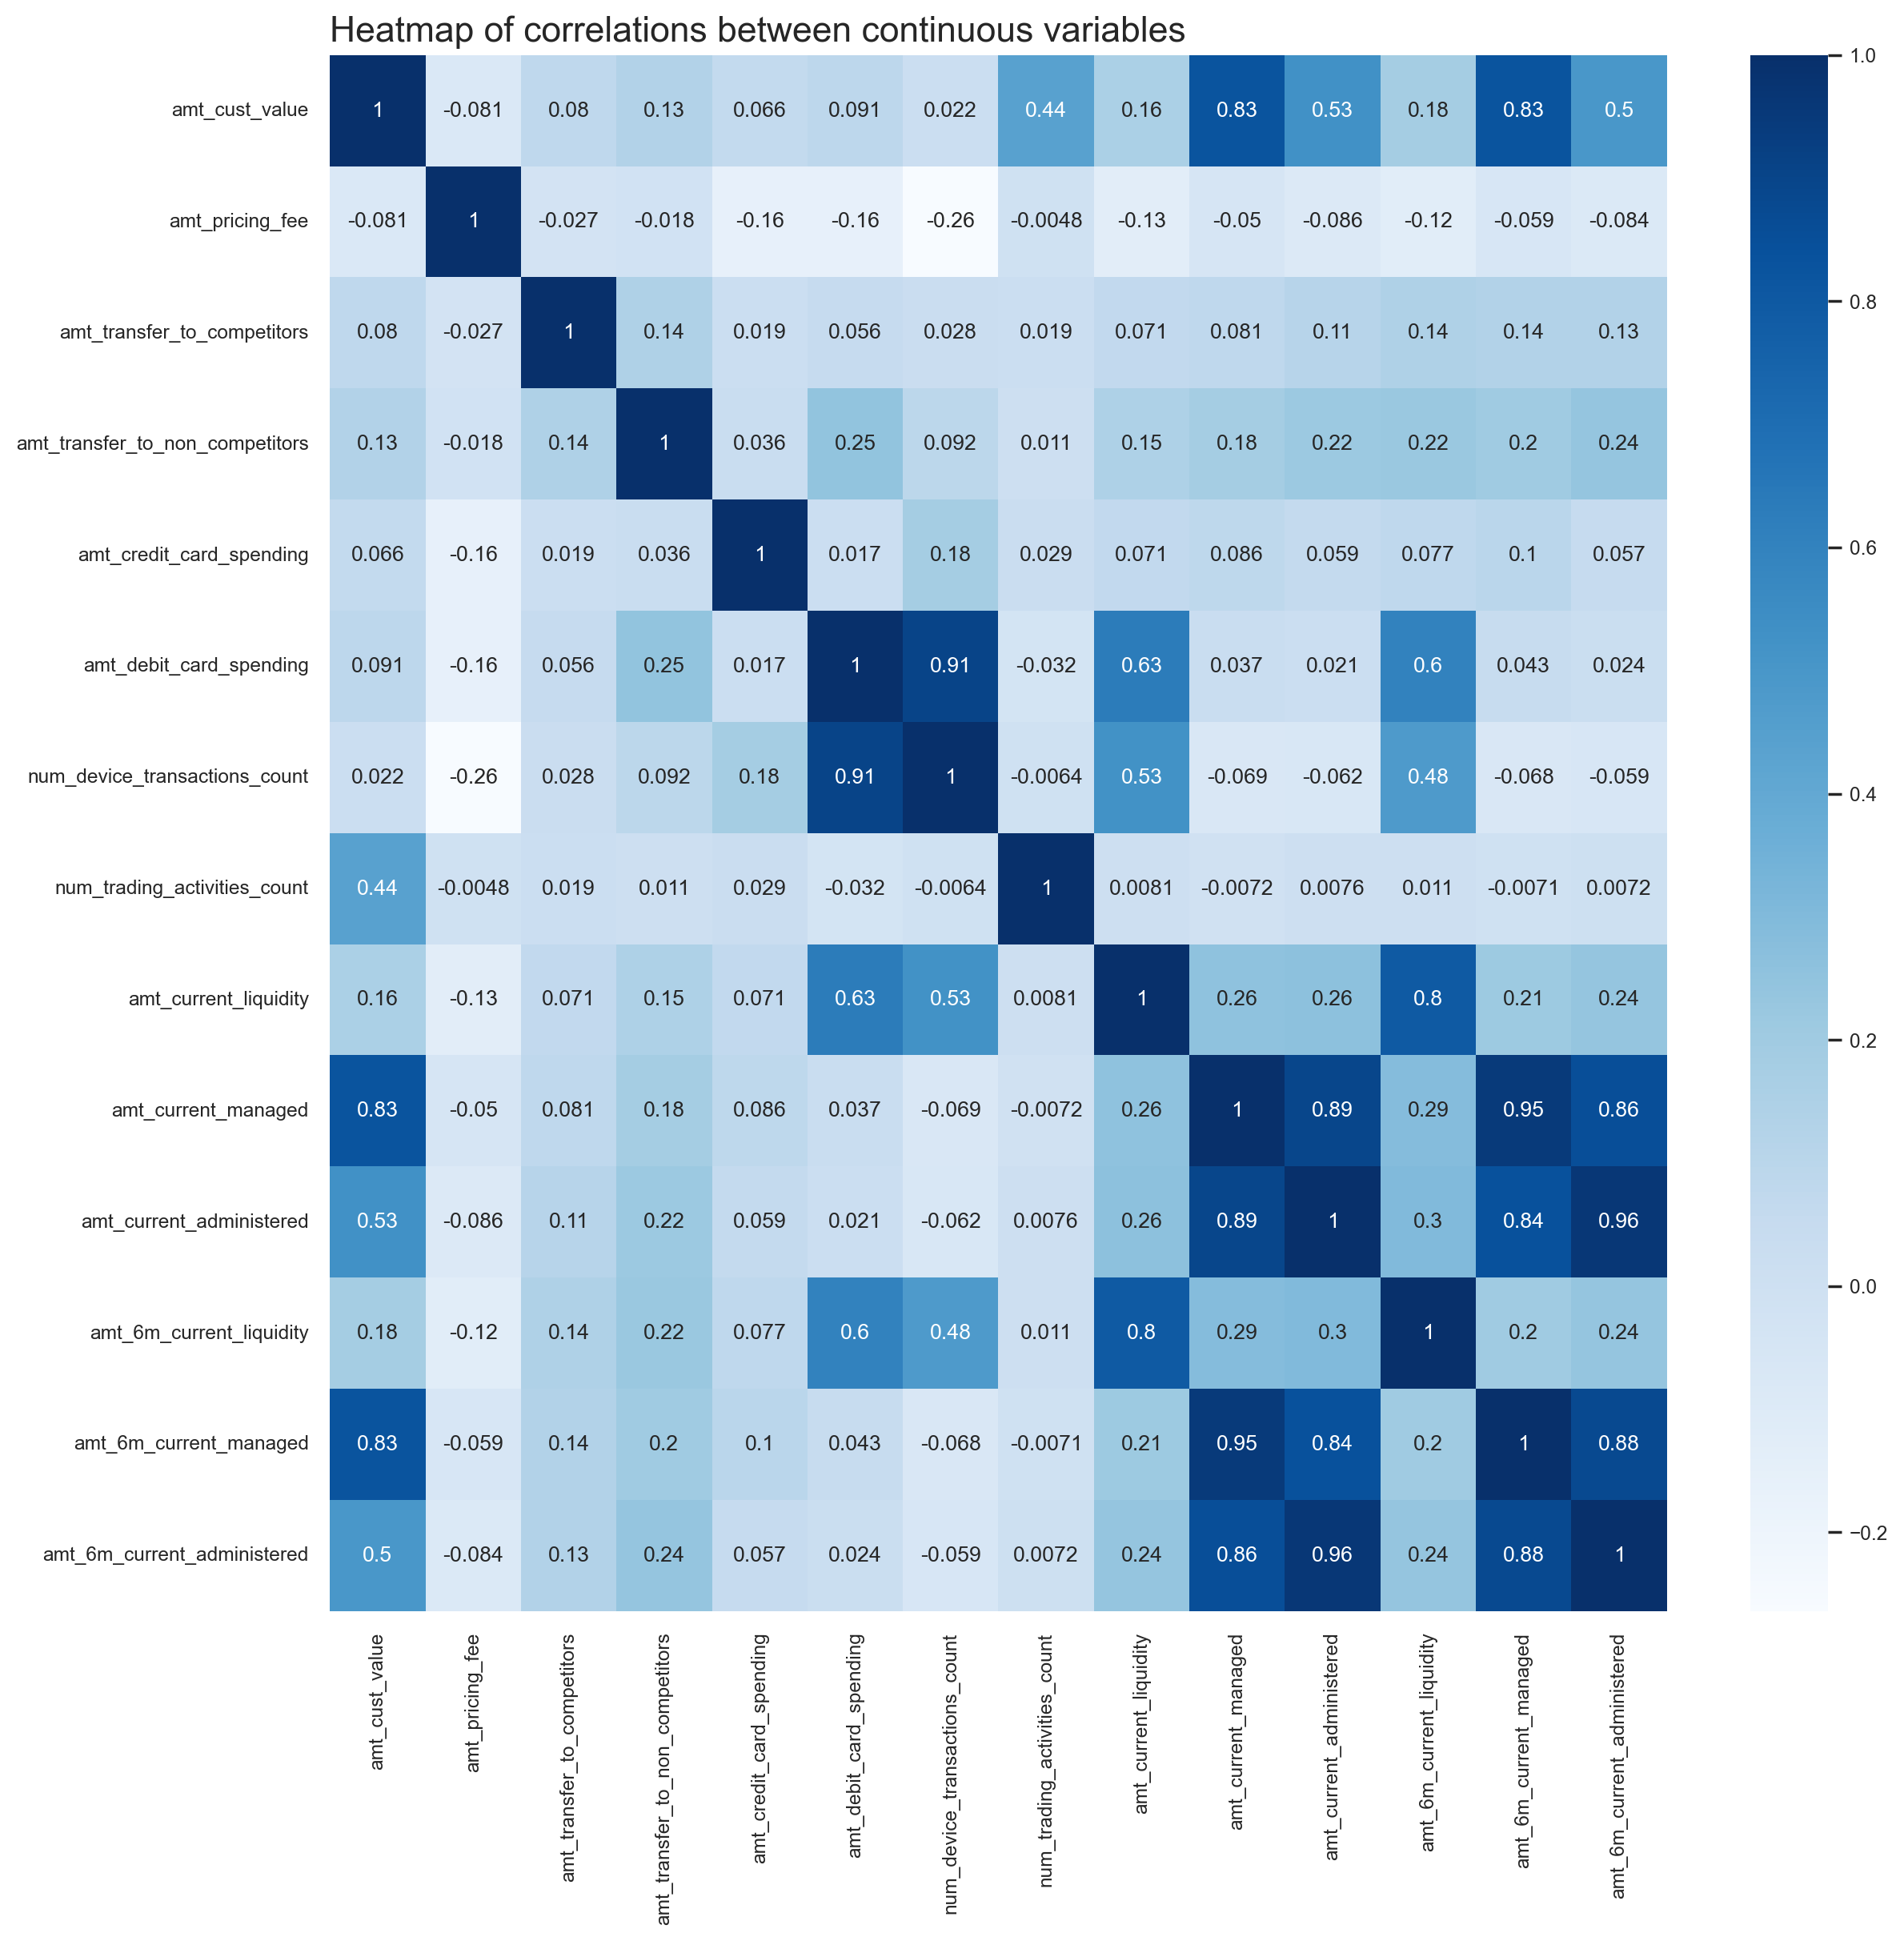

In [57]:
# create heatmap to explore correlations between continuous variables
plt.figure(figsize=(12, 12))
plt.title('Heatmap of correlations between continuous variables', loc='left', fontsize = 16)
sns.heatmap(df[continuous_vars].corr(), cmap='Blues', annot=True)
plt.show()

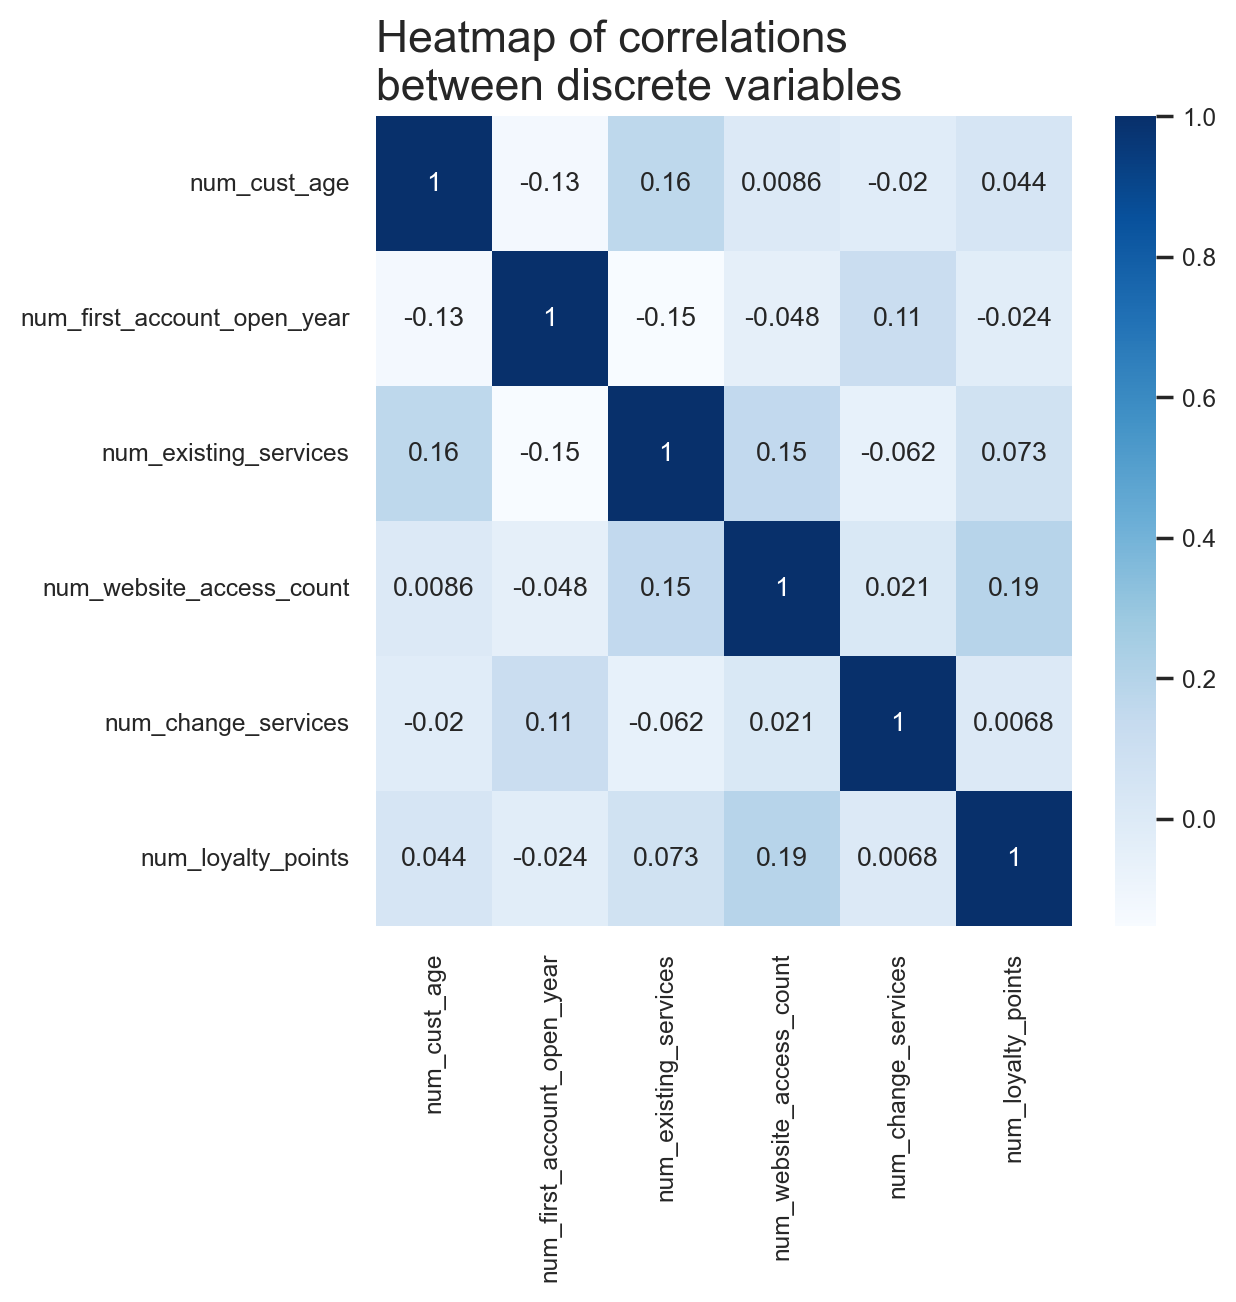

In [58]:
# create heatmap to explore correlations between discrete variables
plt.figure(figsize=(5, 5))
plt.title('Heatmap of correlations \nbetween discrete variables', loc='left', fontsize = 16)
sns.heatmap(df[discrete_vars].corr(), cmap='Blues', annot=True)
plt.show()

In [55]:
# create a standardised dataframe for quantitative variables
scaler = StandardScaler()
quant_std = scaler.fit_transform(df[quant_vars])

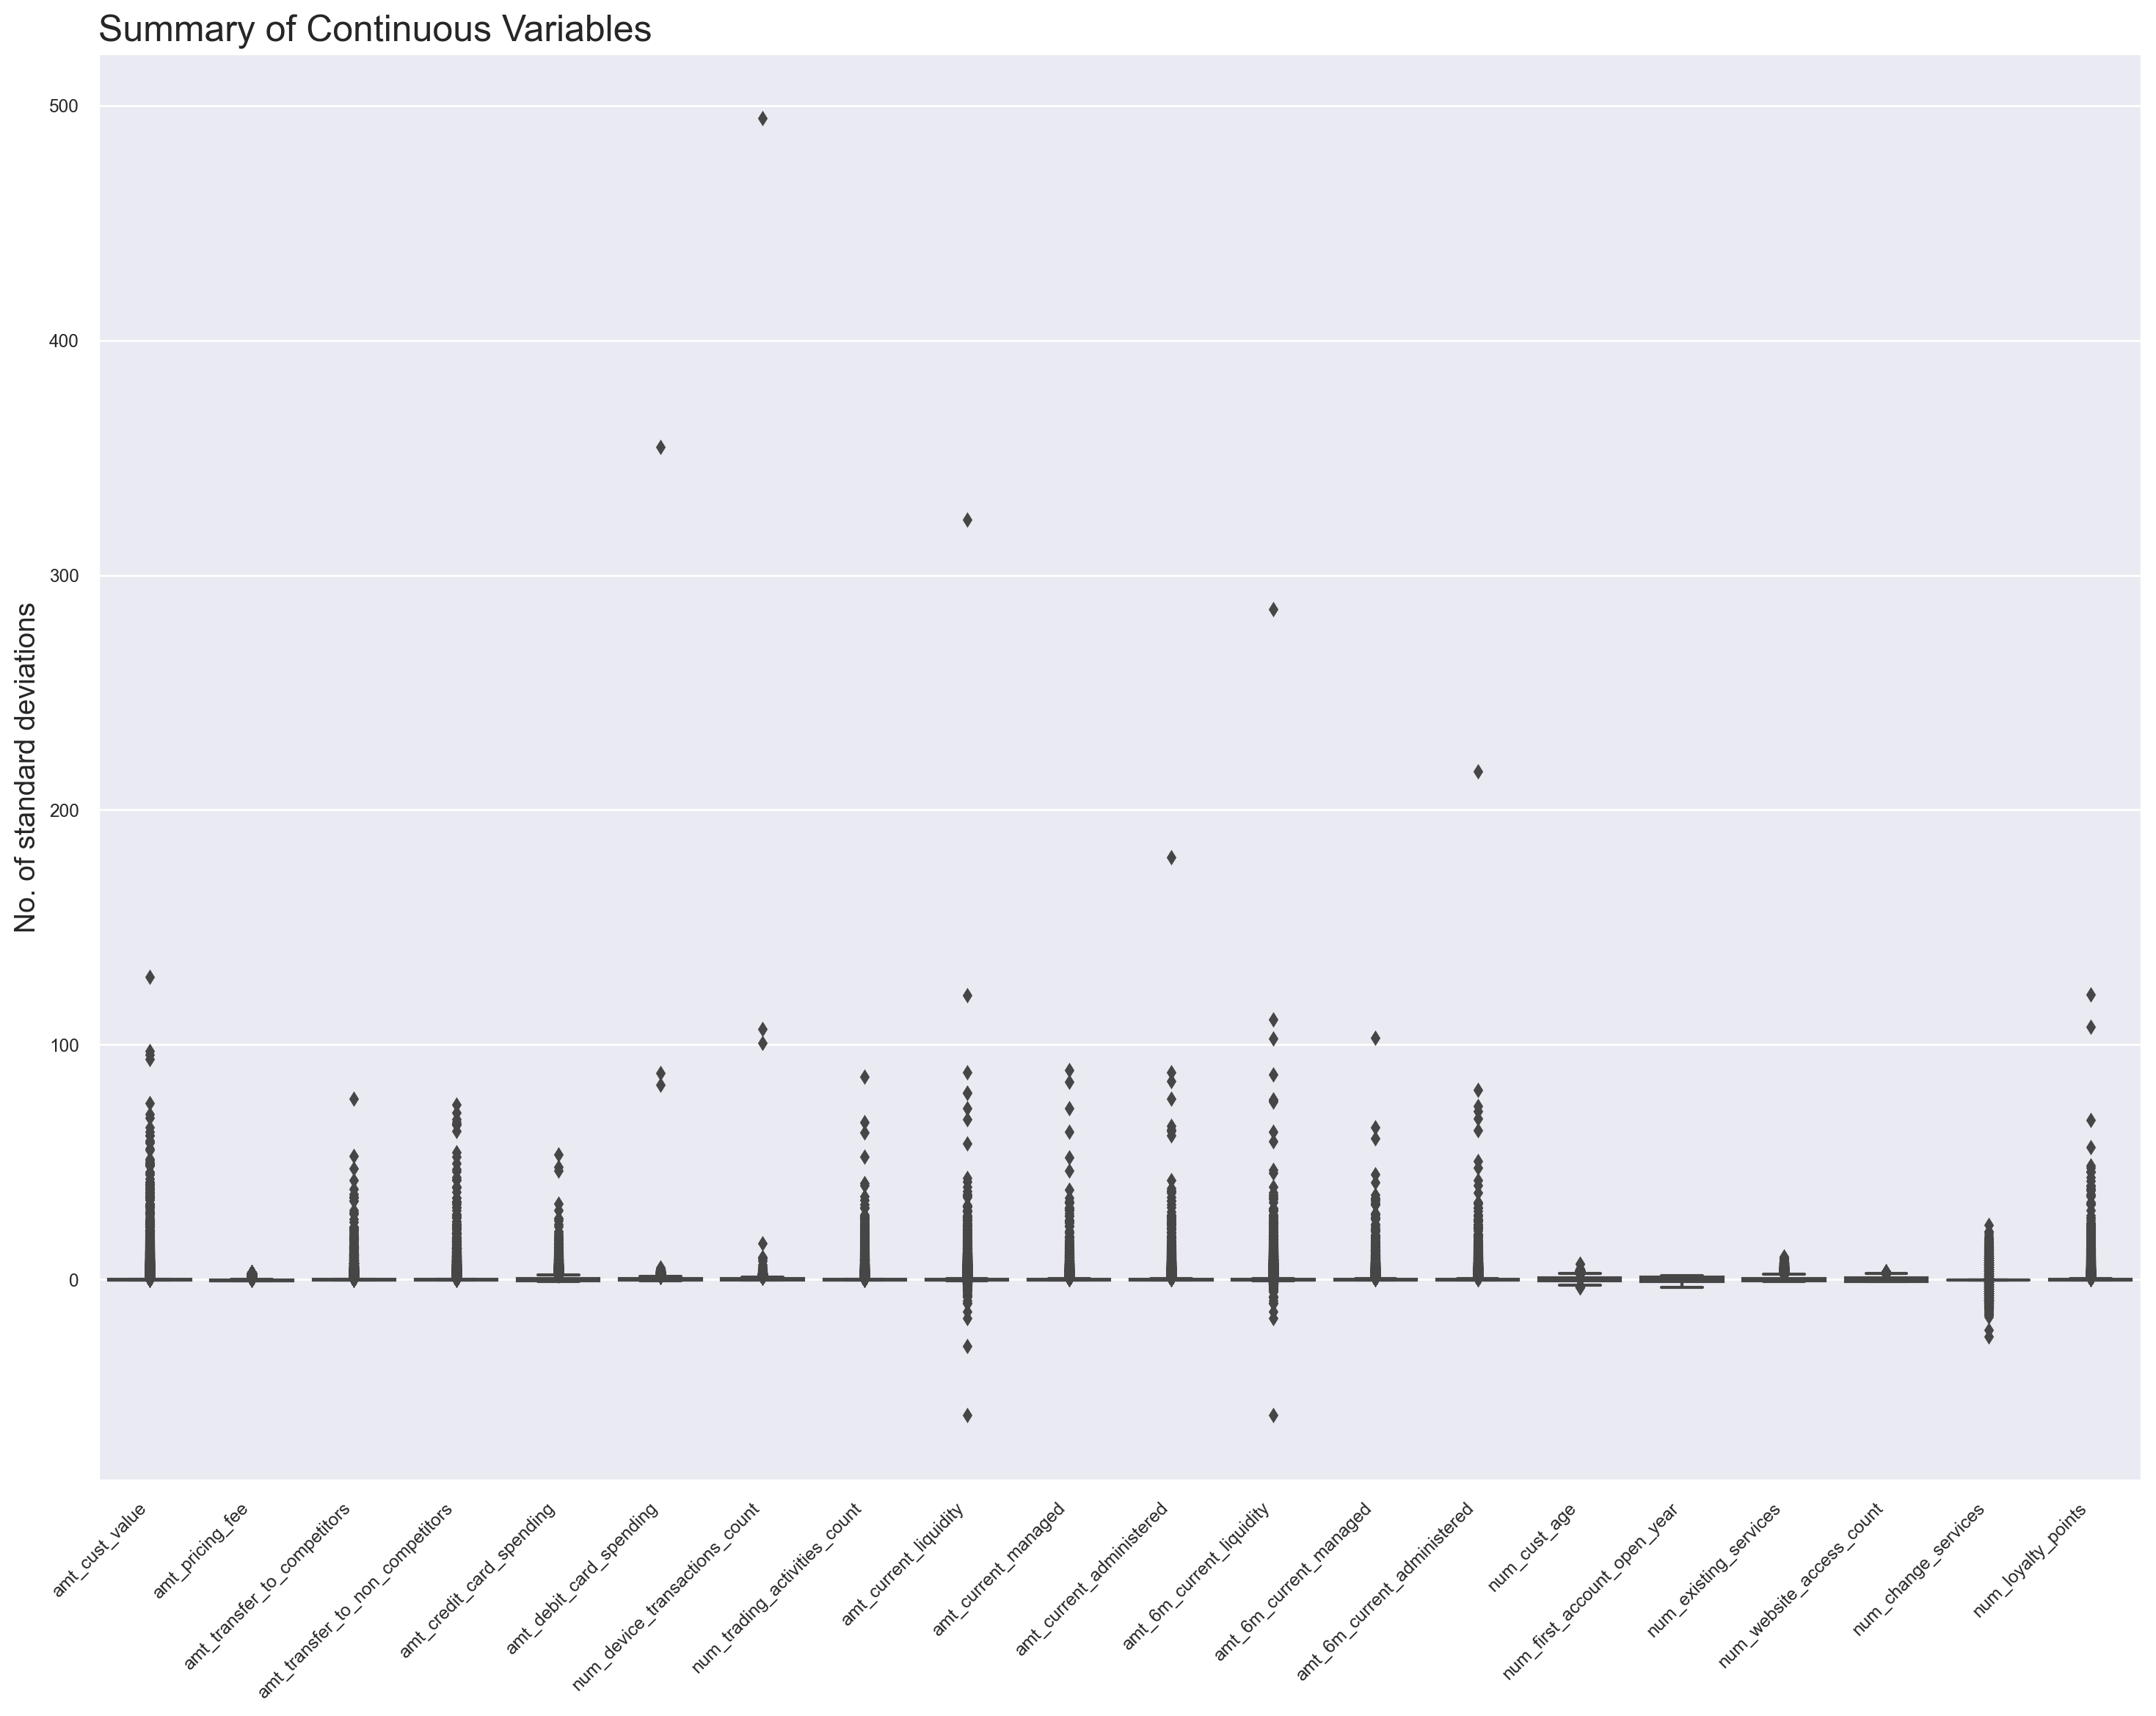

In [56]:
# plot the summary of standardised continuous variables to check for outliers
fig, ax = plt.subplots(figsize = (16,12))

sns.boxplot(data = quant_std, fliersize = 4)
ax.set_title('Summary of Continuous Variables', loc='left', fontsize=18)
ax.set_xticks([x for x in range(len(quant_vars))], labels = quant_vars, rotation = 45, horizontalalignment = 'right')
ax.set_ylabel('No. of standard deviations', fontsize = 14)

plt.show()

In [60]:
# display the average customer value for remaining and closing accounts
cust_value = df.groupby('flag_closure_request')[['amt_cust_value']].mean()
cust_value

,amt_cust_value
flag_closure_request,
0,646.090098
1,374.444534


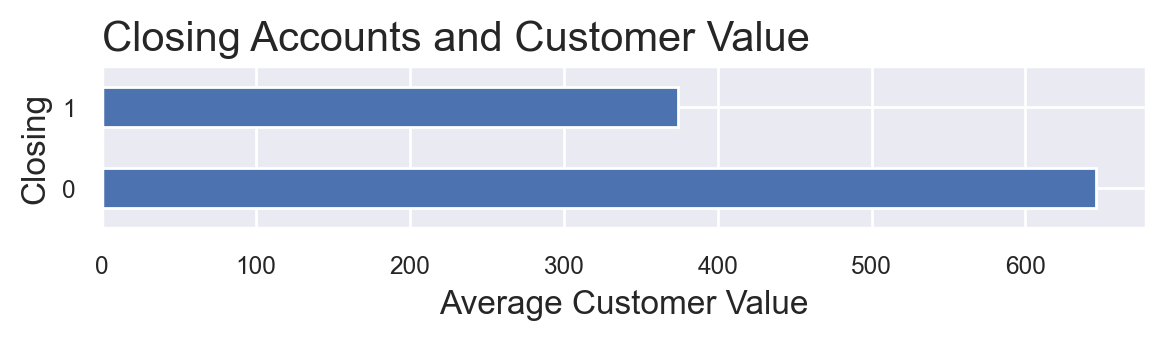

In [61]:
# create a horizontal bar plot showing the average customer value for remaining and closing accounts
cust_value.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Customer Value', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Customer Value', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [62]:
# display the average customer age for remaining and closing accounts
cust_age = df.groupby('flag_closure_request')[['num_cust_age']].mean()
cust_age

,num_cust_age
flag_closure_request,
0,46.023723
1,49.100353


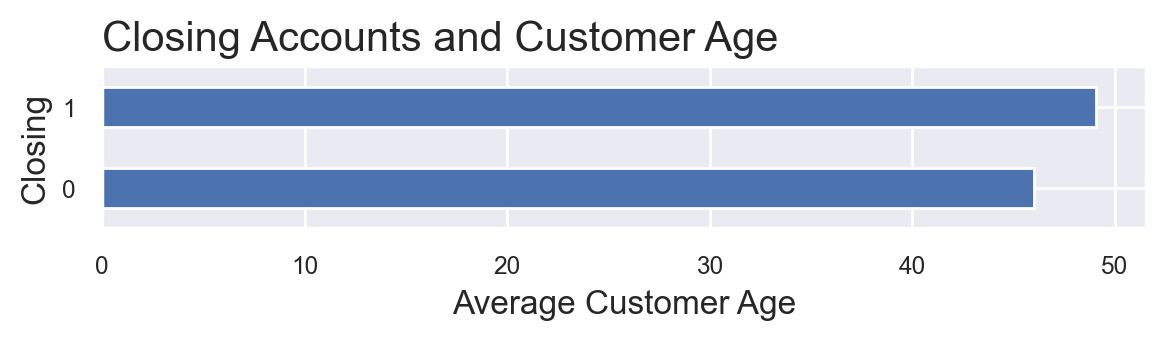

In [63]:
# create a horizontal bar plot showing the average customer age for remaining and closing accounts
cust_age.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Customer Age', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Customer Age', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [65]:
# display the average customer age for remaining and closing accounts
cust_profession = df.groupby('flag_closure_request')[['cust_profession']].mode()
cust_profession

AttributeError: 'DataFrameGroupBy' object has no attribute 'mode'

In [66]:
# display the average transfers to competitors value for remaining and closing accounts
transf_comp = df.groupby('flag_closure_request')[['amt_transfer_to_competitors']].mean()
transf_comp

,amt_transfer_to_competitors
flag_closure_request,
0,3167.316225
1,8402.074078


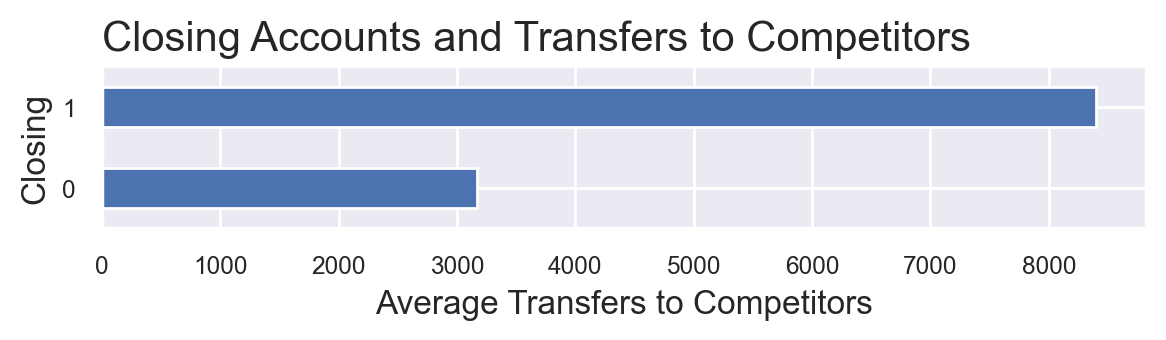

In [67]:
# create a horizontal bar plot showing the average transfers to competitors value for remaining and closing accounts
transf_comp.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Transfers to Competitors', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Transfers to Competitors', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [68]:
# display the average transfers to non competitors value for remaining and closing accounts
transf_non_comp = df.groupby('flag_closure_request')[['amt_transfer_to_non_competitors']].mean()
transf_non_comp

,amt_transfer_to_non_competitors
flag_closure_request,
0,3308.909997
1,15855.200363


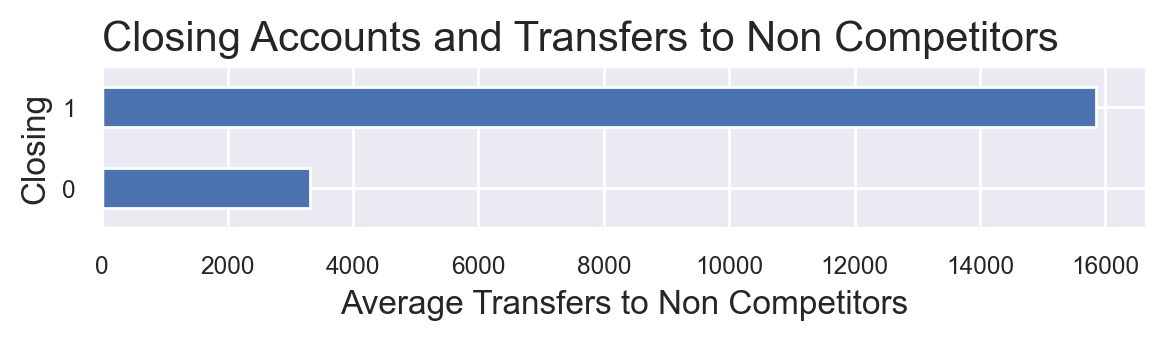

In [69]:
# create a horizontal bar plot showing the average transfers to non competitors value for remaining and closing accounts
transf_non_comp.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Transfers to Non Competitors', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Transfers to Non Competitors', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

## Exporting the database tables

The 11 tables will be exported as **CSV** files, which will be used to create a semantic model in **Power BI** and related dashboards in the next step.  
  
  <br/><br/>